In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [28]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_182/func_0/'

In [29]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 741 presented stimuli.
starts_angle_0: 184. starts_angle_180: 184


In [30]:
starts_loom = []
for i in range(len(angles)):
    if angles[i] == None:
        continue
    if np.isnan(angles[i]):
        starts_loom.append(int(stimulus_start_times[i]*100))

In [31]:
starts_translation = []
for i in range(len(angles)):
    if angles[i] == None:
        starts_translation.append(int(stimulus_start_times[i]*100))

In [32]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [33]:
def extract_traces(fictrac, stim_times, pre_window, post_window):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac['Y'][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [34]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac,
                                                                starts_loom,
                                                                pre_window,
                                                                post_window)

In [35]:
##Find the indicies of trials where the speed decreased past a certain threshold (presumed freezing)
diffs = behavior_traces[:,200] - behavior_traces[:,220]
threshold = 2
slow_ind = np.where(diffs>threshold)[0]

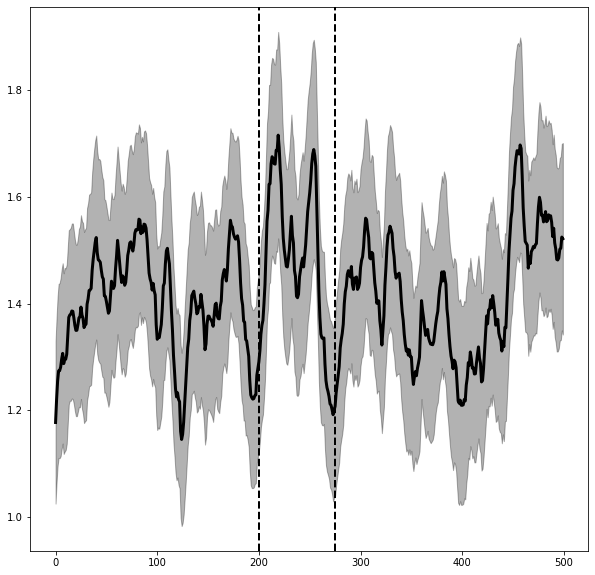

In [36]:
# plotting all average behavior around the looming stim
plt.figure(figsize=(10,10))
plt.plot(mean_trace,color='k',linewidth=3)
plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
for line in [200,275]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

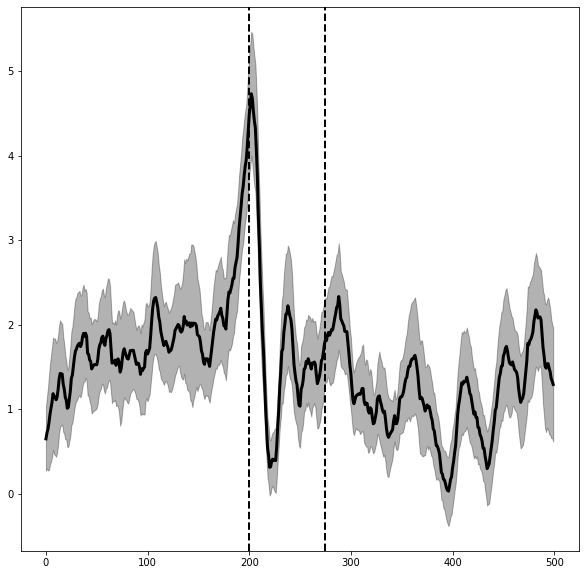

In [37]:
#Only plotting behavior of the trials where the fly froze

freeze_trials = np.zeros([len(slow_ind), np.shape(behavior_traces)[1]])
x = 0
for i in range(len(behavior_traces)):
    if i in slow_ind:
        freeze_trials[x] = behavior_traces[i, :]
        x+=1
avg_freeze = np.mean(freeze_trials, axis=0)
sem_freeze = scipy.stats.sem(freeze_trials,axis=0)

plt.figure(figsize=(10,10))
plt.plot(avg_freeze,color='k',linewidth=3)
plt.fill_between(np.arange(len(avg_freeze)),avg_freeze-sem_freeze, avg_freeze+sem_freeze, color='k',alpha=0.3)
for line in [200,275]:
    plt.axvline(line,color='k',linestyle='--',lw=2)


In [38]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

# load neural

In [39]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

FileNotFoundError: [Errno 2] No such file or directory: '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_182/func_0/clustering/cluster_labels.npy'

In [ ]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
atlas = brainsss.load_roi_atlas()

In [40]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [24]:
bin_start = -500; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# STA wrapped

In [41]:
starts_loom_ms = [i*10 for i in starts_loom]

In [42]:
freeze_starts = np.zeros(len(slow_ind))
x = 0
for i in range(len(starts_loom)):
    if i in slow_ind:
        freeze_starts[x] = starts_loom[i]
        x+=1

freeze_starts_ms = [n*10 for n in freeze_starts]

In [43]:
freeze_starts = []
for ind in slow_ind:
    freeze_starts.append(starts_loom[ind])
#freeze_starts = np.asarray(freeze_starts)
freeze_starts_ms = [n*10 for n in freeze_starts]

non_freeze_starts = []

for i in range(len(starts_loom)):
    if i in slow_ind:
        continue
    else:
        non_freeze_starts.append(starts_loom[i])
non_freeze_starts_ms = [n*10 for n in non_freeze_starts]

In [44]:
t0 = time.time()
STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = freeze_starts_ms, #starts_loom_ms,#starts_angle_ms[180],#starts_loom,
                                   neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

STA 0.6388251781463623


In [45]:
STA_brain = np.nan_to_num(STA_brain)

In [46]:
reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)

In [47]:
reformed_STA_brain.shape

(49, 24, 256, 128)

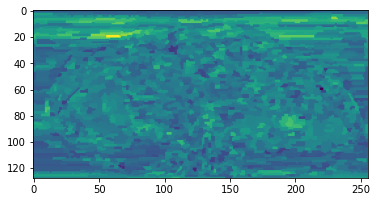

In [48]:
plt.imshow(reformed_STA_brain[25,13,:,:].T,)

In [49]:
reformed_STA_brain.shape

(49, 24, 256, 128)

In [50]:
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [51]:
t0 = time.time()
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_180', fixed=fixed, anat_to_mean_type='myr')
print(F'Warps {time.time()-t0}')

Warps 18.085853338241577


In [52]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [53]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                       diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

Explosion 43.04586124420166


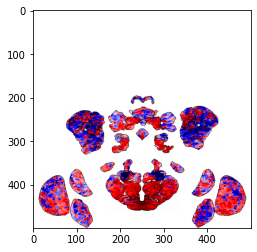

In [54]:
plt.imshow(explosions[10])

In [57]:
movie_dir = os.path.join(func_path, 'movies')
os.mkdir(movie_dir)

In [58]:
save_dir = os.path.join(movie_dir,'non_freeze_loom')
os.mkdir(save_dir)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
